In [1]:
# Enable autoreload of libraries on execution
%load_ext autoreload
%autoreload 2

%load_ext tensorboard

from tqdm import tqdm

# Dataset Exploration


In [2]:
dataset_path = r"G:\VM\Shared Folder\bags\0001.bag"
EVENTS_TOPIC = "/cam0/events"
IMAGES_TOPIC = "/cam0/image_raw"

# dataset_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\03 - Dataset\CED_simple\simple_jenga_destroy.bag"
# EVENTS_TOPIC = "/dvs/events"
# IMAGES_TOPIC = "/dvs/image_color"

## Dataset Inspection


### Inspect messages content


In [ ]:
from dataset_utils import inspect_bag
inspect_bag(dataset_path)

##### **Image events content:**

**data**: binary image data encoded according to encoding

**encoding**: format used to encode the image data - e.g. mono8, bgr8

**width**, **height**: size of the image

**is_bigendian**: endianness of image

**step**: full row length in bytes

**header**:

-   **seq**: consecutively increasing ID
-   **stamp**:
    -   **secs**: seconds since epoch
    -   **nsecs**: nanoseconds since stamp.secs
-   **frame_id**: frame this data is associated with - in this dataset is always empty

##### **Event events content:**

**events**: array of events

**width**, **height**: size of the camera sensor

**header**:

-   **seq**: consecutively increasing ID
-   **stamp**:
    -   **secs**: seconds since epoch
    -   **nsecs**: nanoseconds since stamp.secs
-   **frame_id**: frame this data is associated with - in this dataset is always empty

##### **Events format:**

**x**, **y**: coordinates of the pixel sensor

**polarity**: polarity of the event in {True, False}

**ts**:

-   **secs**: seconds since epoch
-   **nsecs**: nanoseconds since ts.secs


### Inspect message timestamps


In [ ]:
from dataset_utils import inspect_message_timestamps
inspect_message_timestamps(dataset_path, events_topic=EVENTS_TOPIC, images_topic=IMAGES_TOPIC)


The events are not completely sequential, since there can be two image events after each other (e.g. 6-7) but the first event timestamp of the next event is before the last image (e.g 8).

Moreover, there are some events that are acquired after the last image has been captured.


## Dataset Analysis

### Dataset Loading

In [ ]:
from dataset_utils import load_bag_as_dataframes
events_df, images_df = load_bag_as_dataframes(dataset_path, events_topic=EVENTS_TOPIC, images_topic=IMAGES_TOPIC, max_events=1e6)
print("Events dataframe")
display(events_df)
print("Images dataframe")
display(images_df)


Events and frames are already ordered by timestamp, since they are produced from a real simulation.


### Number of events per image frame

Check how many events there are among each image frame.

This roughly reflects the amount of movement in the sequence.


In [ ]:
from dataset_utils import plot_number_of_events_per_frame
plot_number_of_events_per_frame(events_df, images_df)

### Check image frames frequency


In [ ]:
from dataset_utils import plot_image_frames_frequency
plot_image_frames_frequency(images_df)

### Save events for visualization


In [ ]:
from media_utils import save_visual_bayer_events, save_visual_accumulated_events

w, h = images_df.iloc[0].width, images_df.iloc[0].height
folder_name = os.path.basename(dataset_path).replace(".bag", "")
output_dir = os.path.join(os.path.dirname(dataset_path), folder_name)
save_visual_bayer_events(events_df, w, h, os.path.join(output_dir, "visual_events"))
save_visual_accumulated_events(events_df, w, h, os.path.join(output_dir, "visual_images"))

# Metadata parsing (old logs)

In [ ]:
import json

metadata_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\05 - Experiments\2022-08-31 15-36-51\metadata.json"
with open(metadata_path, encoding="utf8") as f:
    data = json.load(f)

In [ ]:
import matplotlib.pyplot as plt

print("Number of epochs:", len(data["epochs"]))
train_loss = [epoch["train_loss"] for epoch in data["epochs"]]
valid_loss = [epoch["valid_loss"] for epoch in data["epochs"]]
plt.plot(range(len(data["epochs"])), train_loss, color="blue", label="Training Loss")
plt.plot(range(len(data["epochs"])), valid_loss, color="orange", label="Valid loss")
plt.legend()
plt.show()

In [ ]:
from dataset_utils import dataset_generator_from_bag, save_events_frames_view
# path = r"G:\CED Datasets\simple_color_keyboard_2.bag"
# gen = dataset_generator_from_bag(path, "/dvs/events", "/dvs/image_color", min_n_events=10000, crop_size=(128, 128))
path = r"G:\VM\Shared Folder\bags\DIV2K_0.5\0804.bag"
gen = dataset_generator_from_bag(path, "/cam0/events", "/cam0/image_raw", crop_size=(128, 128))
save_events_frames_view("signore.mp4", gen, model=model, denorm=True)

# Tests

## RAM Image Callback Test

In [ ]:
import pytorch_lightning as pl
import torch

from utils import KerasProgressBar, LogImagesCallback

class UselessModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.param = torch.nn.parameter.Parameter(torch.tensor(0, dtype=torch.float32))

    def forward(self, x):
        return self.param

    def training_step(self, train_batch, batch_idx):
        return np.random.rand() - self.param

    def validation_step(self, val_batch, batch_idx):
        return np.random.rand() - self.param
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)


model = UselessModel()

callbacks = []
train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))
callbacks.append(LogImagesCallback(train_batch, valid_batch, n=5, n_epochs=1))
callbacks.append(KerasProgressBar())

logger = pl.loggers.TensorBoardLogger(experiments_dir, "test CB")
log_every = 50
if len(train_dataloader) < log_every:
    log_every = 1

trainer = pl.Trainer(max_epochs=500, callbacks=callbacks, accelerator="gpu", logger=logger, log_every_n_steps=log_every, enable_progress_bar=True)
trainer.fit(model, train_dataloader, valid_dataloader)

## LPIPS Test

In [ ]:
from torchvision.models import vgg19, VGG19_Weights
from scipy.ndimage import gaussian_filter
from torch.nn.functional import mse_loss
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
import torch

features_outputs = []

img_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\03 - Dataset\CED_simple\simple_color_keyboard_1\color_images\0.png"
img2_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\03 - Dataset\CED_simple\simple_color_keyboard_1\color_images\130.png"
img3_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\03 - Dataset\CED_simple\simple_fruit\color_images\0.png"
img = plt.imread(img_path)[:,:,:3]
img_noise = img * np.random.rand(*img.shape)
img_blur = gaussian_filter(img, sigma=(5, 5, 0))
img2 = plt.imread(img2_path)[:,:,:3]
img3 = plt.imread(img3_path)[:,:,:3]

plt.figure(figsize=(10, 5))
plt.imshow(np.hstack((img, img_noise, img_blur, img2, img3)))
plt.show()

img = torch.Tensor(img).permute(2, 0, 1).unsqueeze(0)
img_noise = torch.Tensor(img_noise).permute(2, 0, 1).unsqueeze(0)
img_blur = torch.Tensor(img_blur).permute(2, 0, 1).unsqueeze(0)
img2 = torch.Tensor(img2).permute(2, 0, 1).unsqueeze(0)
img3 = torch.Tensor(img3).permute(2, 0, 1).unsqueeze(0)

vgg_weights = VGG19_Weights.IMAGENET1K_V1
vgg = vgg19(weights=vgg_weights)
vgg.eval()
vgg_preprocess = vgg_weights.transforms()

# train_nodes, eval_nodes = get_graph_node_names(vgg)
# print(train_nodes)

VGG_LAYER = "features.35"
vgg_extractor = create_feature_extractor(vgg, [VGG_LAYER])

features_img = vgg_extractor(vgg_preprocess(img))[VGG_LAYER]
features_noise = vgg_extractor(vgg_preprocess(img_noise))[VGG_LAYER]
features_blur = vgg_extractor(vgg_preprocess(img_blur))[VGG_LAYER]
features_img2 = vgg_extractor(vgg_preprocess(img2))[VGG_LAYER]
features_img3 = vgg_extractor(vgg_preprocess(img3))[VGG_LAYER]

mse_noise = mse_loss(img, img_noise)
mse_blur = mse_loss(img, img_blur)
mse_same = mse_loss(img, img)
mse_img2 = mse_loss(img, img2)
mse_img3 = mse_loss(img, img3)

print(f"{'MSE:':10}  same - {mse_same:.4f}, noise - {mse_noise:.4f}, blur - {mse_blur:.4f}, img2 - {mse_img2:.4f}, img3 - {mse_img3:.4f}")

mse_features_noise = mse_loss(features_img, features_noise)
mse_features_blur = mse_loss(features_img, features_blur)
mse_features_same = mse_loss(features_img, features_img)
mse_features_img2 = mse_loss(features_img, features_img2)
mse_features_img3 = mse_loss(features_img, features_img3)

print(f"{'LPIPS:':10}  same - {mse_features_same:.4f}, noise - {mse_features_noise:.4f}, blur - {mse_features_blur:.4f}, img2 - {mse_features_img2:.4f}, img3 - {mse_features_img3:.4f}")



## Binary File Reading

In [ ]:
from dataset_utils import dataset_generator_from_bag, dataset_generator_from_binary, save_samples_to_disk
import time
import torch
import numpy as np

bag_file_path = r"G:\VM\Shared Folder\bags\COCO\000000000139.bag"
bin_file_path = r"G:\VM\Shared Folder\bags\COCO\000000000139.bin"


bag_gen = dataset_generator_from_bag(bag_file_path, events_topic="/cam0/events", image_topic="/cam0/image_raw")
save_samples_to_disk(bag_gen, "test_bag_batches", False)
bag_gen = dataset_generator_from_bag(bag_file_path, events_topic="/cam0/events", image_topic="/cam0/image_raw")
save_samples_to_disk(bag_gen, "test_bag_batches_compressed", True)
bin_gen = dataset_generator_from_binary(bin_file_path)
save_samples_to_disk(bin_gen, "test_bin_batches", False)
bin_gen = dataset_generator_from_binary(bin_file_path)
save_samples_to_disk(bin_gen, "test_bin_batches_compressed", True)

for i, (bagf, binf) in enumerate(zip(bag_gen, bin_gen)):
    events_equal = np.array_equal(bagf[0], binf[0])
    img_equal = np.array_equal(bagf[1], binf[1])
    print(events_equal, img_equal)

## Colors channeling (scrapped for now)

In [ ]:
import numpy as np
import torch

batch = 2
bins = 2
w = 16
h = 16

x = torch.arange(0, batch*bins*w*h) + 1
x = x.reshape(batch, bins, h, w)

# x = x.reshape(batch, bins, h // 4, w // 4, 2, 2, 2, 2)

r = x[:, :, ::2, ::2]
g = x[:, :, ::2, 1::2]
G = x[:, :, 1::2, ::2]
b = x[:, :, 1::2, 1::2]
x = torch.stack((r,g,G,b), dim=2).squeeze()
print(x.shape, x)

# x = x.transpose(4, 5)
# x = x.transpose(5, 7)

# x = x.reshape(batch, bins, 4, h // 2, w // 2)
# x = x.permute(0, 1, 5, 3, 2, 4)

## Dataset events values range

In [8]:
from dataset import DIV2KDataset

DIV2K_DATASET_PATH = r"C:\datasets\DIV2K_5_fix"
datasets = ["{:04}".format(i) for i in range(1, 900 + 1)]

mins = []
maxs = []
for dataset in datasets:
    d = DIV2KDataset(DIV2K_DATASET_PATH, sequences=[dataset], crop_size=(128, 128), preload_to_RAM=True, normalize_events=True)
    v_min, v_max = None, None
    for events, img in d:
        d_min, d_max = events.min(), events.max()
        if v_min is None or d_min < v_min:
            v_min = d_min
        if v_max is None or d_max > v_max:
            v_max = d_max
    mins.append(d_min)
    maxs.append(d_max)

print(min(mins), max(maxs))

-0.11908084 0.118364096


## Events integration colors

Warning, there are no events between two frames, skipping one.


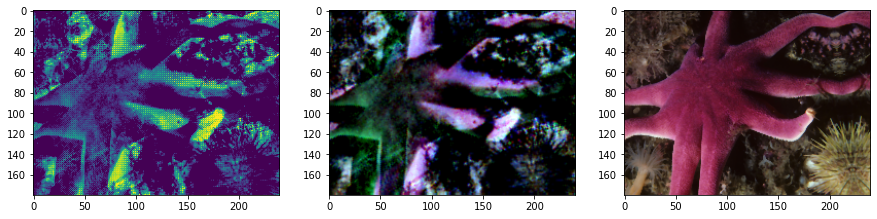

Warning, there are no events between two frames, skipping one.


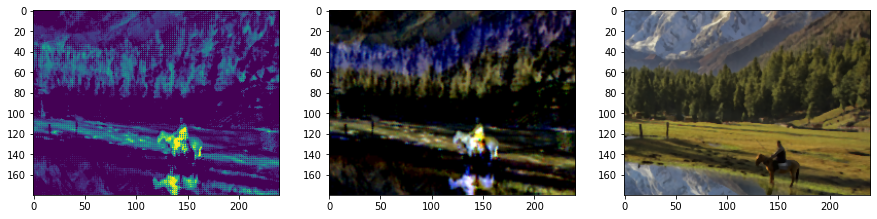

Warning, there are no events between two frames, skipping one.


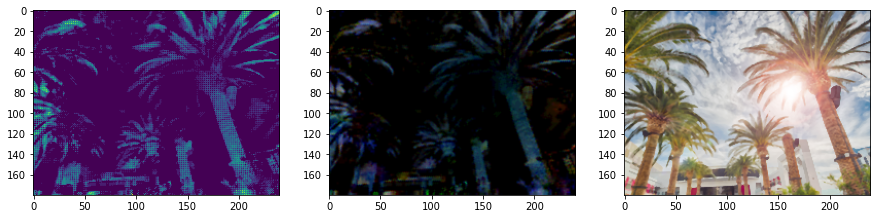

Warning, there are no events between two frames, skipping one.


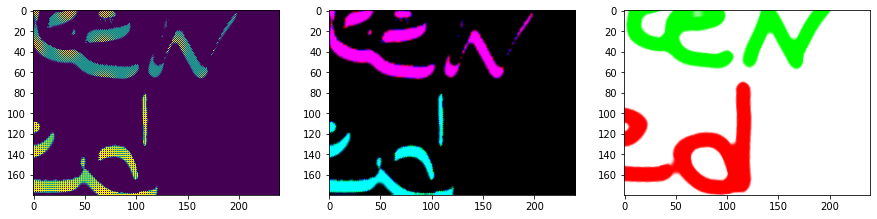

Warning, there are no events between two frames, skipping one.


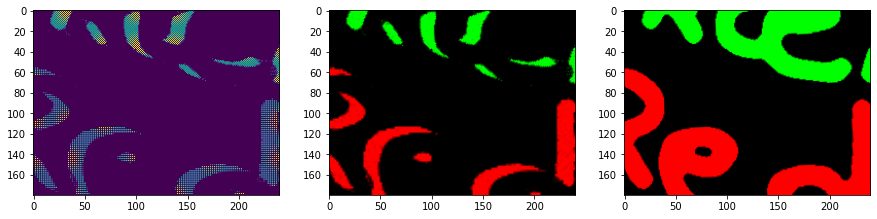

Warning, there are no events between two frames, skipping one.


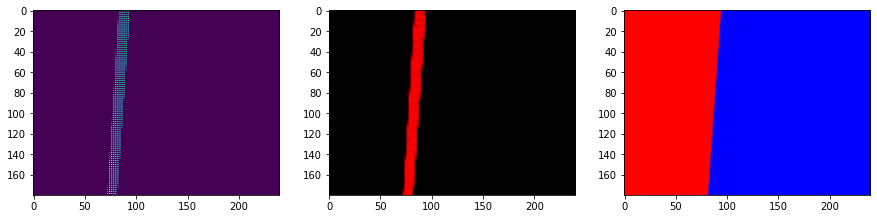

Warning, there are no events between two frames, skipping one.


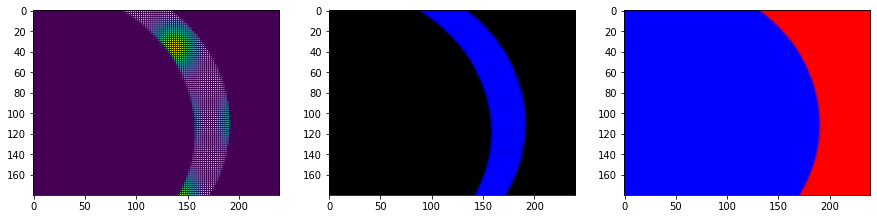

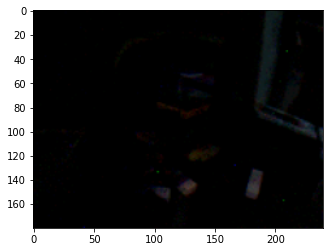

In [96]:
from dataset import DIV2KDataset, CEDDataset
from dataset_utils import dataset_generator_from_bag
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

def demosaic_events_from_generator(gen, contrast_th=15, starting_brightness = 0, n=-1):
    for i, (events, img) in enumerate(gen):
        events_sum = starting_brightness + (np.sum(events, axis=0) * contrast_th)
        events_sum = events_sum.clip(0, 255).astype(np.uint8)
        demosaic = cv2.demosaicing(events_sum, cv2.COLOR_BAYER_RGGB2RGB)
        
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(events_sum)
        axs[1].imshow(demosaic)
        axs[2].imshow(img)
        plt.show()

        if i == (n - 1):
            break

def quarter_colors_reconstruction_from_generator(gen, contrast_th=15, starting_brightness = 0, n=-1):   
    for i, (events, img) in enumerate(gen):
        events_sum = starting_brightness + (np.sum(events, axis=0) * contrast_th)
        events_sum = events_sum.clip(0, 255).astype(np.uint8)

        r = events_sum[0::2, 0::2]
        g = (events_sum[0::2, 1::2] + events_sum[1::2, 0::2]) // 2
        b = events_sum[1::2, 1::2]

        img = np.stack((r,g,b), axis=-1)
        img_up = cv2.resize(img, (120 * 2, 90 * 2))
        plt.imshow(img_up)
        plt.show()

        if i == (n - 1):
            break

# DIV2K_DATASET_PATH = r"C:\datasets\DIV2K_5_fix"
# div2k_gen = DIV2KDataset(DIV2K_DATASET_PATH, sequences=["0001"])

# CED_PATH = r"G:\VM\Shared Folder\simple_color_keyboard_2.bag"
# CED_PATH = r"G:\CED Datasets\simple_wires_1.bag"
CED_PATH = r"G:\CED Datasets\simple_jenga_1.bag"
# ced_gen = dataset_generator_from_bag(CED_PATH, "/dvs/events", "/dvs/image_color", min_n_events=500_000)

div2kpaths = [
    r"G:\VM\Shared Folder\0001.bag",
    r"G:\VM\Shared Folder\0002.bag",
    r"G:\VM\Shared Folder\0003.bag",
    r"G:\VM\Shared Folder\test_image.bag",
    r"G:\VM\Shared Folder\test_image_black.bag",
    r"G:\VM\Shared Folder\red_blue.bag",
    r"G:\VM\Shared Folder\blue_circle.bag",
]

for path in div2kpaths:
    gen = dataset_generator_from_bag(path, "/cam0/events", "/cam0/image_raw")
    demosaic_events_from_generator(gen, n=1)

gen = dataset_generator_from_bag(CED_PATH, "/dvs/events", "/dvs/image_color", min_n_events=700_000)
quarter_colors_reconstruction_from_generator(gen, n=1)



## Representations for thesis

In [1]:
import rosbag
import os
import numpy as np
import matplotlib.pyplot as plt
from dataset_utils import dataset_generator_from_bag
# path = r"G:\CED Datasets\Bags\simple_color_keyboard_2.bag"
# path = r"C:\datasets\CEDDataset\driving_tunnel_sun.bag"
path = r"C:\datasets\CEDDataset\simple_jenga_destroy.bag"

### Event Voxel Grid Explanation

In [ ]:
# Event stream
# DIV2K Examples
from tqdm import tqdm
from dataset import DIV2KDataset
from dataset_utils import rosbag_images_generator
base_path = r"G:\VM\Shared Folder\bags\DIV2K_0.5"
bags = [
    "0001.bag",
    # "0015.bag",
    # "0075.bag",
]

n_frames = 6

for bag in bags:
    path = os.path.join(base_path, bag)

    with rosbag.Bag(path) as b:
        img_gen = iter(rosbag_images_generator(b, "/cam0/image_raw"))
        og_imgs = [next(img_gen) for i in range(n_frames)]
        # og_imgs = [img for img in img_gen]

    og_events = []
    with rosbag.Bag(path) as b:
        messages = b.read_messages(topics=["/cam0/events"])
        i = 0
        for topic, msg, timestamp in messages:
            events = msg.events
            for event in events:
                event_obj = [event.x, event.y, event.ts.to_sec(), event.polarity]
                og_events.append(event_obj)

    fig = plt.figure(figsize=(30, 30))

    ax = fig.add_subplot(1, 1, 1, projection='3d', computed_zorder=True)
    ax.w_xaxis.set_pane_color((0.5, .5, .5, 1))
    ax.w_yaxis.set_pane_color((0.5, .5, .5, 1))
    ax.w_zaxis.set_pane_color((0.5, .5, .5, 1))

    # ax.set_xlabel('x')
    # ax.set_ylabel('t')
    # ax.set_zlabel('y')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    # ax.set_facecolor("#7f7f7f")

    # ax.set_xlim(-30, 375)
    # ax.set_ylim(-0.05, 1.05)
    # ax.set_zlim(-25, 285)

    ax.view_init(15, 15)
    ax.set_box_aspect(aspect = (1,6,1))

    
    xs, ys, ts, ps = zip(*og_events[::1500])

    ts = np.array(ts)
    tmin = ts.min()
    tmax = ts.max()
    ts = (ts - tmin) / (tmax - tmin)
    
    colors = ["#fff" if p else "#000" for p in ps]
    

    cur_image_idx = 1
    prev_idx = 0

    cur_image_ts, cur_image = og_imgs[cur_image_idx]
    cur_image_ts = (cur_image_ts - tmin) / (tmax - tmin)
    for i, t in enumerate(tqdm(ts)):
        img = cur_image / 255.0
        X, Y = np.ogrid[0:cur_image.shape[1], 0:cur_image.shape[0]]
        img = img.transpose(1, 0, 2)
        Z = np.ones_like(X) * cur_image_ts

        if t > cur_image_ts:
            print(i-prev_idx, "Events")
            
            ax.plot_surface(X, Z, Y, rstride=1, cstride=1, shade=False, facecolors=img)
            
            ax.scatter(xs[prev_idx:i], ts[prev_idx:i], ys[prev_idx:i], s=15, color=colors[prev_idx:i], marker="s")
            prev_idx = i
            
            cur_image_idx += 1
            
            if cur_image_idx == len(og_imgs):
                break
            
            cur_image_ts, cur_image = og_imgs[cur_image_idx]
            cur_image_ts = (cur_image_ts - tmin) / (tmax - tmin)
            print("cur_image_idx", cur_image_idx)
    
    ax.set_zlim(max(ax.get_zlim()), min(ax.get_zlim()))
    plt.savefig("div2k_bag_" + bag.replace(".bag", "") + ".png", transparent=True, bbox_inches='tight')
    # plt.show()

    # break

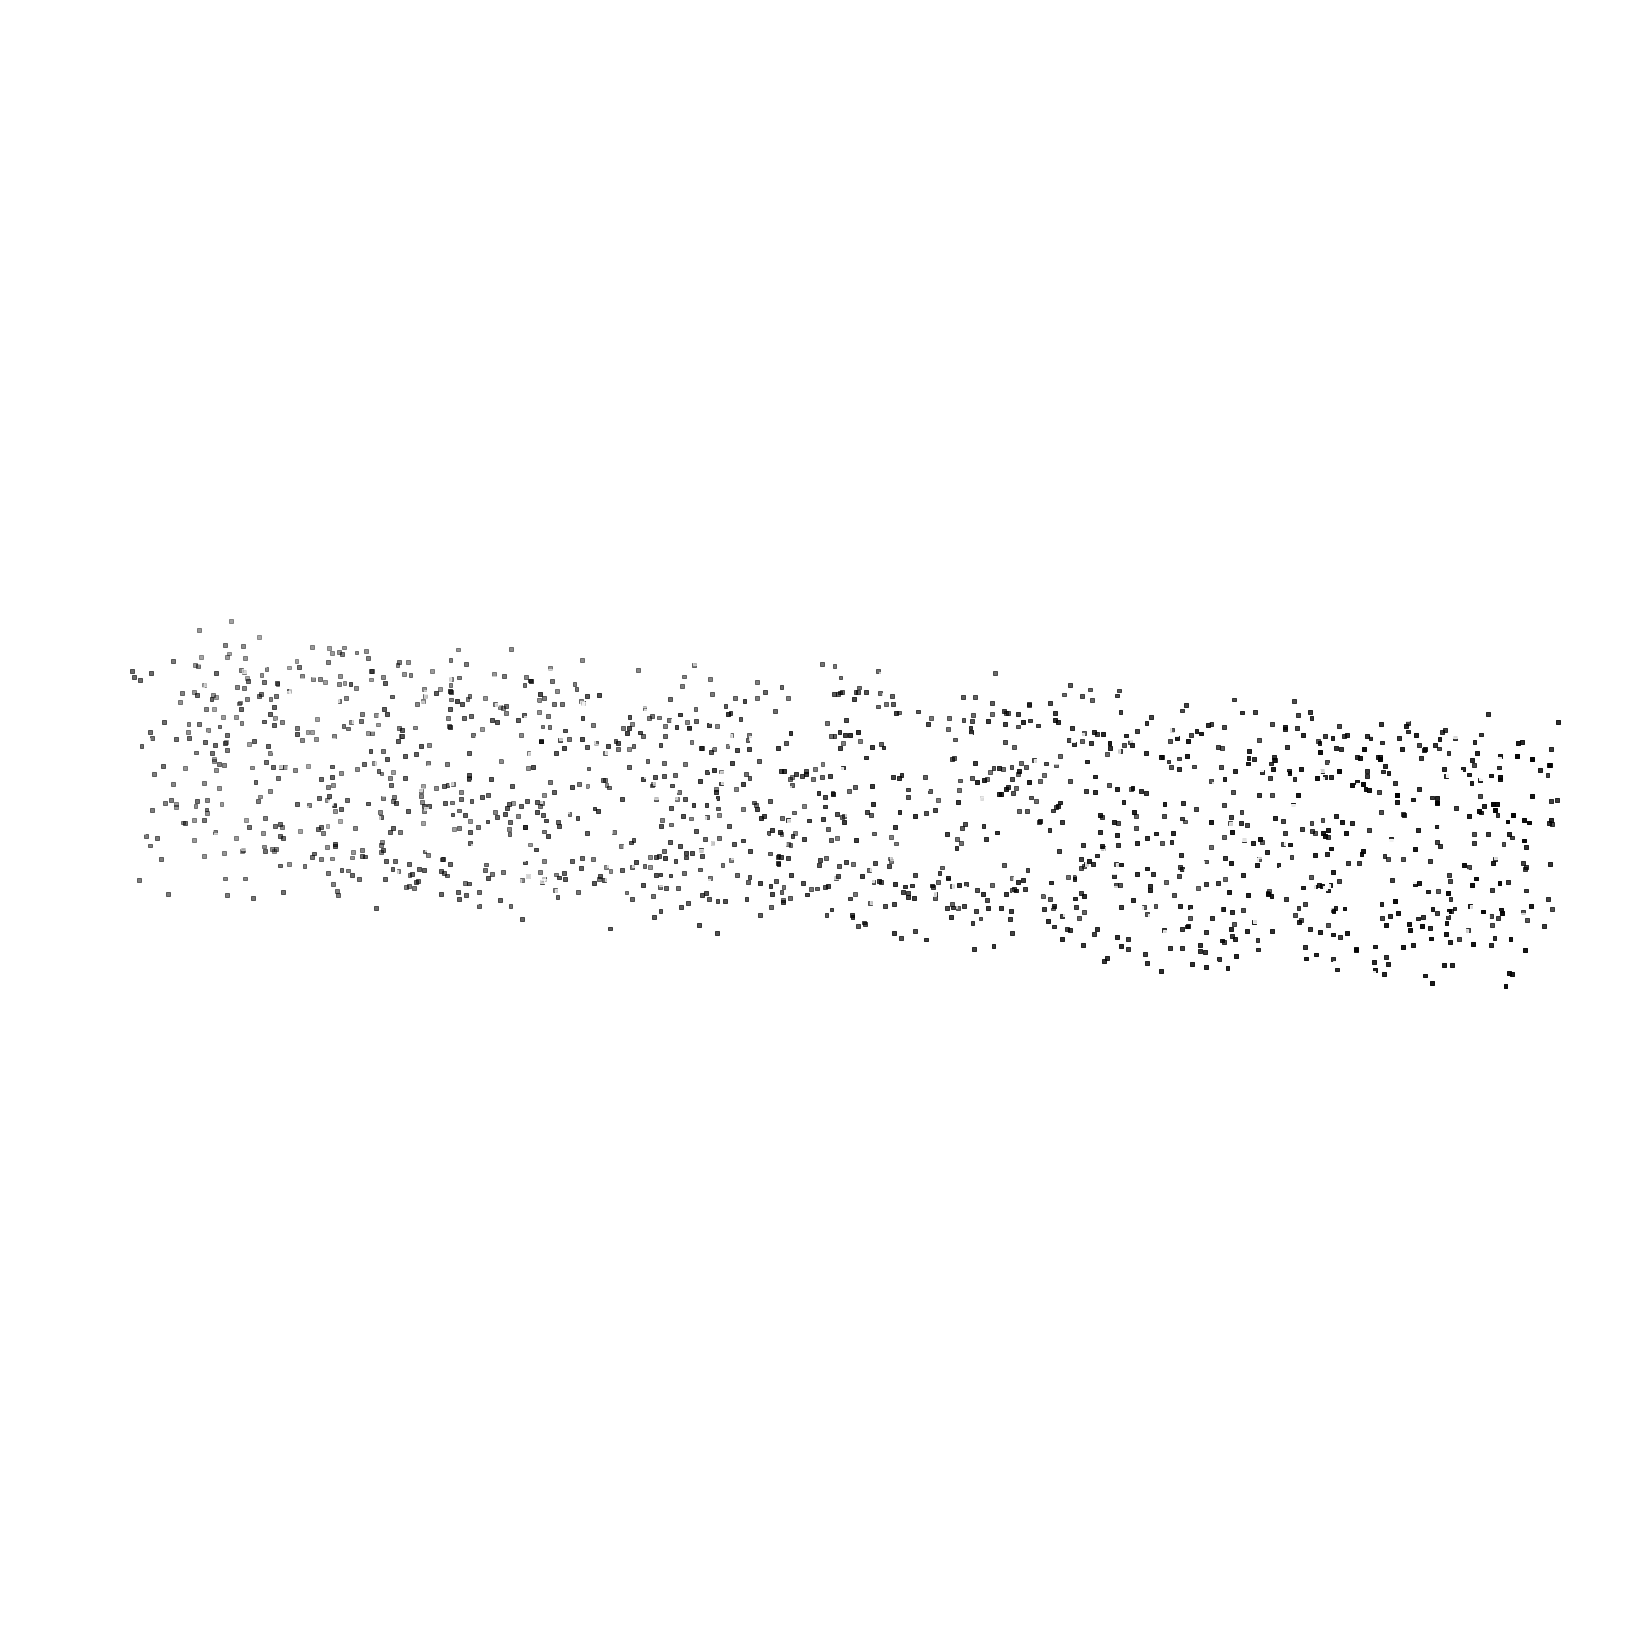

In [5]:
# DIV2K Examples
from tqdm import tqdm
from dataset import DIV2KDataset
from dataset_utils import rosbag_images_generator
bag_path = r"G:\VM\Shared Folder\bags\DIV2K_0.5\0001.bag"

og_events = []
with rosbag.Bag(bag_path) as b:
    messages = b.read_messages(topics=["/cam0/events"])
    i = 0
    for topic, msg, timestamp in messages:
        events = msg.events
        for event in events:
            event_obj = [event.x, event.y, event.ts.to_sec(), event.polarity]
            og_events.append(event_obj)

fig = plt.figure(figsize=(30, 30))

ax = fig.add_subplot(1, 1, 1, projection='3d', computed_zorder=True)

ax.view_init(15, 15)
ax.set_box_aspect(aspect = (1,6,1))

xs, ys, ts, ps = zip(*og_events[::1500])

ts = np.array(ts)
tmin = ts.min()
tmax = ts.max()
ts = (ts - tmin) / (tmax - tmin)

colors = ["#fff" if p else "#000" for p in ps]
    
ax.scatter(xs, ts, ys, s=15, color=colors, marker="s")

ax.set_zlim(max(ax.get_zlim()), min(ax.get_zlim()))
plt.axis("off")
plt.savefig("event_stream.png", transparent=True, bbox_inches='tight')

In [9]:
# Extract and accumulate events
n_events = 10000
e_xs = []
e_ys = []
e_ts = []
e_ps = []
imgs = []
with rosbag.Bag(path) as b:
    messages = b.read_messages(topics=["/dvs/events"])
    i = 0
    for topic, msg, timestamp in messages:
        events = msg.events
        for event in events:
            e_xs.append(event.x)
            e_ys.append(event.y)
            e_ts.append(event.ts.to_nsec())
            e_ps.append(event.polarity)
            i += 1
        
            if i == n_events:
                break
        if i == n_events:
            break

# Normalize timestamp between 0 and 1
e_ts = np.array(e_ts)
e_ts = (e_ts - e_ts.min()) / (e_ts.max() - e_ts.min())

In [10]:
# Create bins
nbins = 10
tmin = np.min(e_ts)
tmax = np.max(e_ts)

bins = []
prev_bin = 0
events = []
for x, y, t, p in zip(e_xs, e_ys, e_ts, e_ps):
    bin_ = int(np.floor(t * (nbins)))
    if bin_ == nbins:
        break
    # color = "#fff"
    color = "#000" if not p else "#fff"
    # color = cmap(bin_ / (nbins - 1))
    # color = colors[bin_]
    event = [x, y, t, color]
    if bin_ != prev_bin:
        bins.append(events)
        events = [event]
        prev_bin = bin_
    else:
        events.append(event)
bins.append(events)

# for i, bin_ in enumerate(bins):
#     print(f"i = {i}, events = {len(bin_)}, color = {bin_[0][3]}")

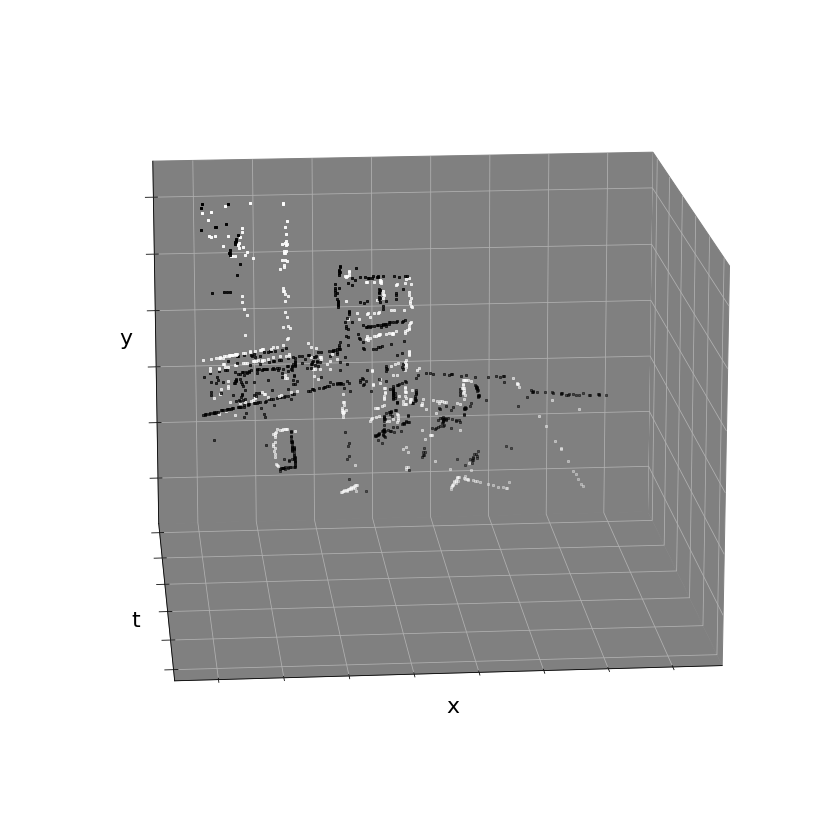

In [20]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(1, 1, 1, projection='3d', computed_zorder=True)
ax.w_xaxis.set_pane_color((0.5, .5, .5, 1))
ax.w_yaxis.set_pane_color((0.5, .5, .5, 1))
ax.w_zaxis.set_pane_color((0.5, .5, .5, 1))

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('y')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.view_init(15, 85)
# ax.set_facecolor("#7f7f7f")


ax.set_xlim(-30, 375)
ax.set_ylim(-0.05, 1.05)
ax.set_zlim(-25, 285)
ax.set_zlim(max(ax.get_zlim()), min(ax.get_zlim()))

plt.savefig("event_grid_00.png", transparent=True, bbox_inches='tight')

for events in bins[:1]:
    xs, ys, ts, colors = zip(*events)
    ax.scatter(xs, 0, ys, s=4, c=colors, marker="s")

# plt.axis("off")
plt.savefig("event_grid_01.png", transparent=True, bbox_inches='tight')
plt.show()

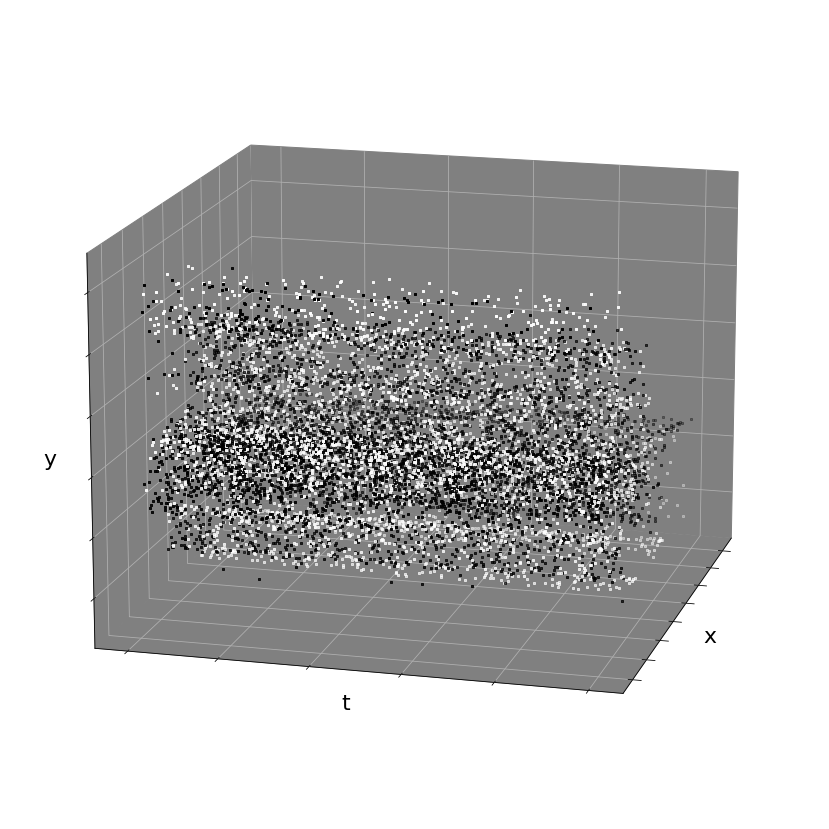

(-30.0, 375.0) (-0.05, 1.05) (285.0, -25.0)


In [21]:
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(1, 1, 1, projection='3d', computed_zorder=True)
ax.w_xaxis.set_pane_color((0.5, .5, .5, 1))
ax.w_yaxis.set_pane_color((0.5, .5, .5, 1))
ax.w_zaxis.set_pane_color((0.5, .5, .5, 1))

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('y')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
# ax.set_facecolor("#7f7f7f")

ax.set_xlim(-30, 375)
ax.set_ylim(-0.05, 1.05)
ax.set_zlim(-25, 285)
ax.set_zlim(max(ax.get_zlim()), min(ax.get_zlim()))

ax.view_init(15, 85)

save_bins = [2, 5, 9]
for j, events in enumerate(bins):
    xs, ys, ts, colors = zip(*events)
    ax.scatter(xs, ts, ys, s=4, c=colors, marker="s")
    if j in save_bins:
        plt.savefig(f"event_grid_1{j}.png", transparent=True, bbox_inches='tight')

ax.view_init(15, 60)
plt.savefig("event_grid_21.png", transparent=True, bbox_inches='tight')
ax.view_init(15, 30)
plt.savefig("event_grid_22.png", transparent=True, bbox_inches='tight')
ax.view_init(15, 15)
plt.savefig("event_grid_23.png", transparent=True, bbox_inches='tight')
plt.show()
print(ax.get_xlim(), ax.get_ylim(), ax.get_zlim())

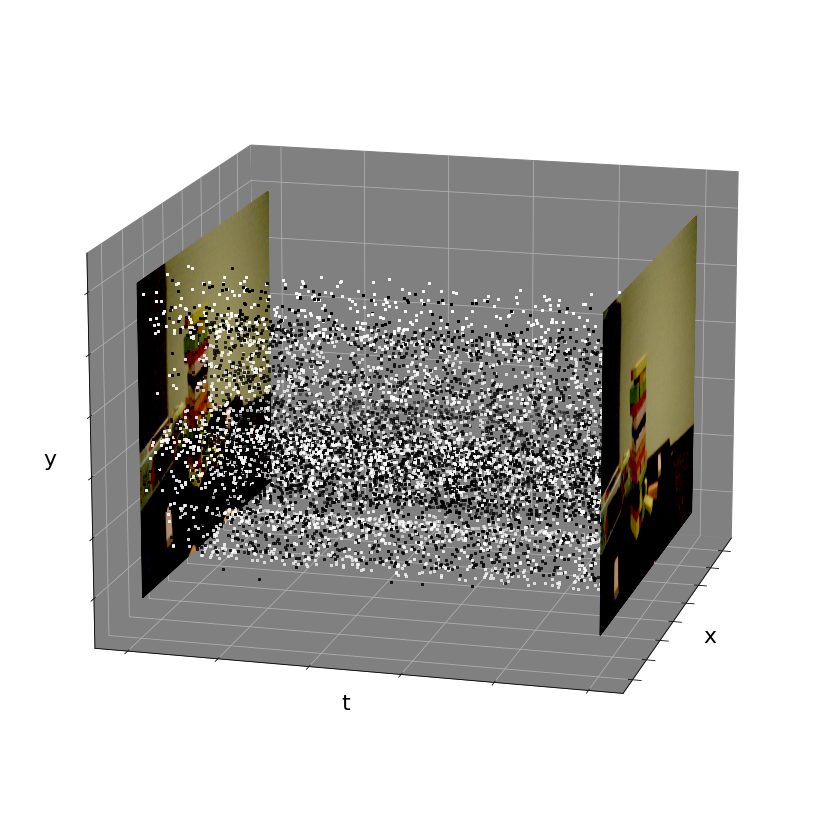

(-30.0, 375.0) (-0.05, 1.05) (285.0, -25.0)


In [23]:
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(1, 1, 1, projection='3d', computed_zorder=True)
ax.w_xaxis.set_pane_color((0.5, .5, .5, 1))
ax.w_yaxis.set_pane_color((0.5, .5, .5, 1))
ax.w_zaxis.set_pane_color((0.5, .5, .5, 1))

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('y')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
# ax.set_facecolor("#7f7f7f")

ax.set_xlim(-30, 375)
ax.set_ylim(-0.05, 1.05)
ax.set_zlim(-25, 285)
ax.set_zlim(max(ax.get_zlim()), min(ax.get_zlim()))

ax.view_init(15, 15)

img = plt.imread("jenga_destroy_0.png")
X, Y = np.ogrid[0:img.shape[1], 0:img.shape[0]]
img = img.transpose(1, 0, 2)
Z = np.zeros_like(X)
surf1 = ax.plot_surface(X, Z, Y, rstride=1, cstride=1, shade=False, facecolors=img)

img = plt.imread("jenga_destroy_15.png")
X, Y = np.ogrid[0:img.shape[1], 0:img.shape[0]]
img = img.transpose(1, 0, 2)
Z = np.ones_like(X)
surf2 = ax.plot_surface(X, Z, Y, rstride=1, cstride=1, shade=False, facecolors=img)

plt.savefig("event_grid_images_0.png", transparent=True, bbox_inches='tight')

surf2.remove()

for j, events in enumerate(bins):
    xs, ys, ts, colors = zip(*events)
    ax.scatter(xs, ts, ys, s=4, c=colors, marker="s")

img = plt.imread("jenga_destroy_15.png")
X, Y = np.ogrid[0:img.shape[1], 0:img.shape[0]]
img = img.transpose(1, 0, 2)
Z = np.ones_like(X)
ax.plot_surface(X, Z, Y, rstride=1, cstride=1, shade=False, facecolors=img)

plt.savefig("event_grid_images_1.png", transparent=True, bbox_inches='tight')
plt.show()
print(ax.get_xlim(), ax.get_ylim(), ax.get_zlim())

(-30.0, 375.0) (-0.05, 1.05) (285.0, -25.0)


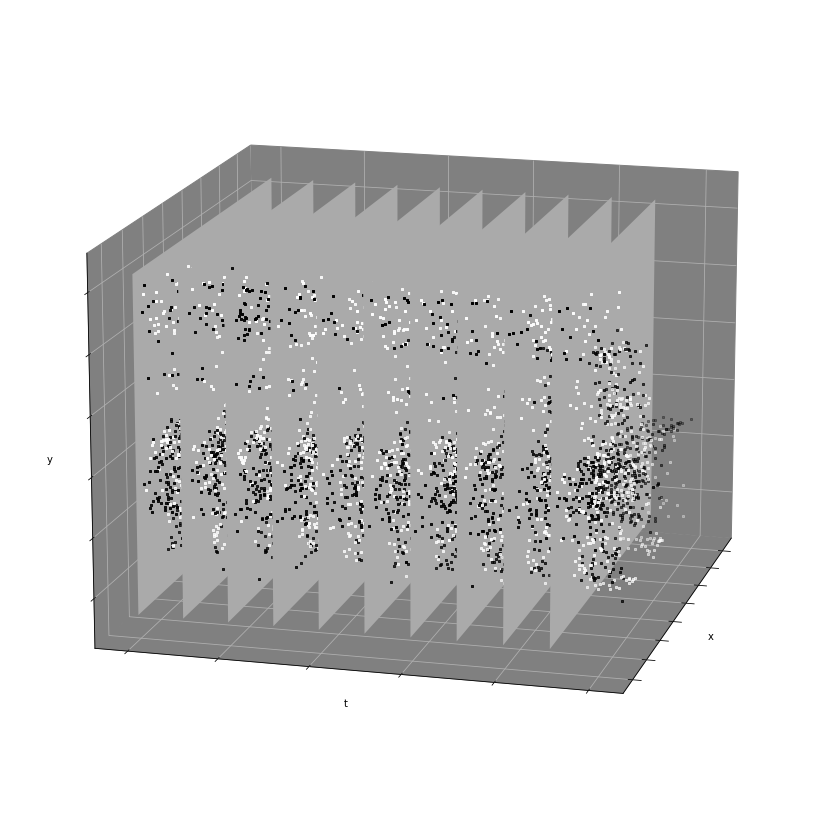

In [10]:
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(1, 1, 1, projection='3d', computed_zorder=False)
ax.w_xaxis.set_pane_color((0.5, .5, .5, 1))
ax.w_yaxis.set_pane_color((0.5, .5, .5, 1))
ax.w_zaxis.set_pane_color((0.5, .5, .5, 1))

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('y')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.view_init(15, 15)

zindex = 0
for j, events in enumerate(bins):
    c = 10 # Planes padding
    X = np.array([[0 - c, 0 - c], [346 + c, 346 + c]])
    Y = np.array([[0 - c, 260 + c], [0 - c, 260 + c]])
    t = j / (len(bins))
    Z = np.array([[t, t], [t, t]])
    # alpha = .8 if i != len(combs) - 1 else .05
    ax.plot_surface(X, Z, Y, color="#aaa", alpha=1, shade=False, zorder=zindex)
    zindex += 1

    xs, ys, ts, colors = zip(*events)
    ax.scatter(xs, ts, ys, s=4, c=colors, zorder=zindex, marker="s")
    zindex += 1
ax.set_xlim(-30, 375)
ax.set_ylim(-0.05, 1.05)
ax.set_zlim(-25, 285)
ax.set_zlim(max(ax.get_zlim()), min(ax.get_zlim()))
plt.savefig("event_grid_30.png", transparent=True, bbox_inches='tight')
print(ax.get_xlim(), ax.get_ylim(), ax.get_zlim())
plt.show()

(-30.0, 375.0) (-0.05, 1.05) (285.0, -25.0)


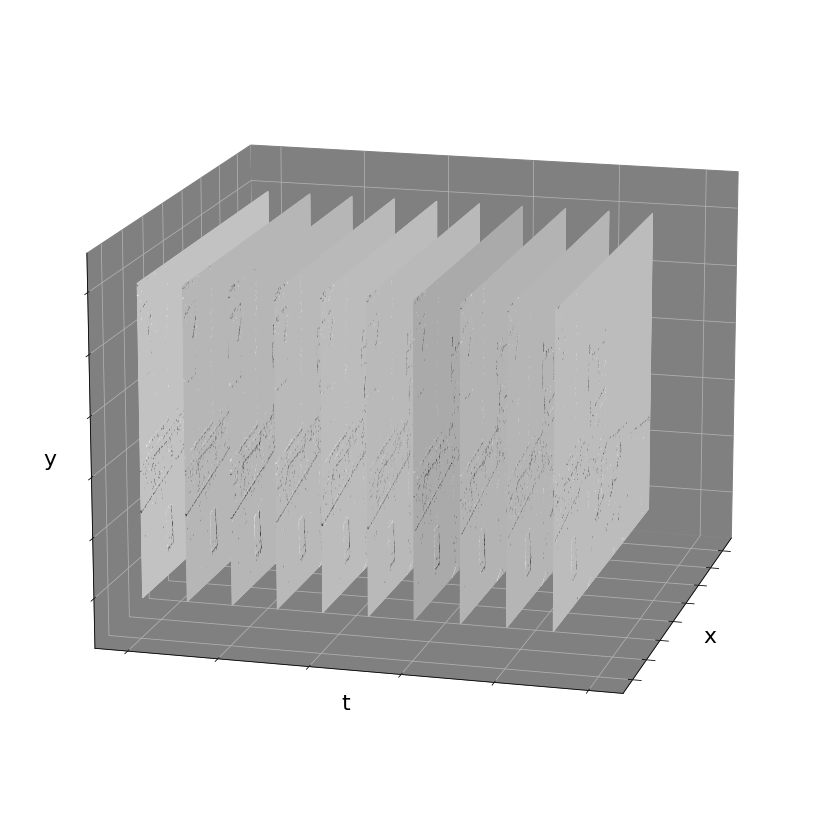

In [82]:
# Create event voxel grid
grid = np.zeros((10, 260, 346))
for x, y, t, p in zip(e_xs, e_ys, e_ts, e_ps):
    bin_ = t * (nbins - 1)
    pol = -1 if not p else 1
    grid[int(bin_), y, x] += pol * 1 - abs(int(bin_) - bin_)
    if (int(bin_) + 1) < len(grid):
        grid[int(bin_) + 1, y, x] += pol * 1 - abs(int(bin_) - bin_)

fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(1, 1, 1, projection='3d', computed_zorder=False)
ax.w_xaxis.set_pane_color((0.5, .5, .5, 1))
ax.w_yaxis.set_pane_color((0.5, .5, .5, 1))
ax.w_zaxis.set_pane_color((0.5, .5, .5, 1))

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('y')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.view_init(15, 15)

for i, bin_ in enumerate(grid):
    X, Y = np.ogrid[0:bin_.shape[1], 0:bin_.shape[0]]
    Z = np.ones_like(X) * (i / (len(grid)))
    colors = np.repeat(bin_[:, :, None], 3, axis=2).transpose(1, 0, 2)
    colors = (colors - colors.min()) / (colors.max() - colors.min())
    # print(X.shape, Y.shape, Z.shape, colors.shape)
    ax.plot_surface(X, Z, Y, rstride=1, cstride=1, shade=False, facecolors=colors)
ax.set_xlim(-30, 375)
ax.set_ylim(-0.05, 1.05)
ax.set_zlim(-25, 285)
ax.set_zlim(max(ax.get_zlim()), min(ax.get_zlim()))
plt.savefig("event_grid_40.png", transparent=True, bbox_inches='tight')
print(ax.get_xlim(), ax.get_ylim(), ax.get_zlim())
plt.show()


### Events representations

In [ ]:
import rosbag
import os
import numpy as np
import matplotlib.pyplot as plt
from dataset_utils import dataset_generator_from_bag
path = r"G:\CED Datasets\simple_color_keyboard_2.bag"

# Event frame
i = 0
n_events = 20_000
image = np.zeros((260, 346))
with rosbag.Bag(path) as b:
    for topic, msg, timestamp in b.read_messages(topics=["/dvs/events"]):
        events = msg.events
        for event in events:
            i += 1
            if event.polarity:
                image[event.y, event.x] = 1
            else:
                image[event.y, event.x] = -1
            
            if i == n_events:
                break
    
        if i == n_events:
            break

plt.figure(figsize=(15, 10))
plt.imshow(image, cmap="gray")
plt.colorbar()
plt.axis("off")
plt.tight_layout()
plt.savefig("event_frame.png")

# Time surface
n_messages = 10
image = np.zeros((260, 346))
with rosbag.Bag(path) as b:
    messages = iter(b.read_messages(topics=["/dvs/events"]))
    for i in range(n_messages):
        topic, msg, timestamp = next(messages)
        events = msg.events
        for event in events:
            image[event.y, event.x] = event.ts.to_nsec()
                
plt.figure(figsize=(15, 10))
plt.imshow(image, cmap="turbo")
plt.colorbar()
plt.axis("off")
plt.tight_layout()
plt.savefig("time_surface.png")

# 3D Point Cloud
n_events = 10000
xs = []
ys = []
ts = []
colors = []
with rosbag.Bag(path) as b:
    messages = b.read_messages(topics=["/dvs/events"])
    i = 0
    for topic, msg, timestamp in messages:
        events = msg.events
        for event in events:
            xs.append(event.x)
            ys.append(event.y)
            ts.append(event.ts.to_nsec())
            color = "red" if event.polarity else "blue"
            colors.append(color)
            i += 1
        
            if i == n_events:
                break
        if i == n_events:
            break
ts = np.array(ts)
ts = (ts - ts.min()) / (ts.max() - ts.min())

fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(xs, ys, ts, c=colors, s=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('ts')
ax.view_init(40, 0)
plt.xlim(max(plt.xlim()), min(plt.xlim()))

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(xs, ys, ts, c=colors, s=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('ts')
ax.view_init(88, 90)
plt.xlim(max(plt.xlim()), min(plt.xlim()))

plt.tight_layout()
plt.savefig("3d_point_cloud.png")

# Voxel Grid
for events, img in dataset_generator_from_bag(path):
    for i, bin_ in enumerate(events):
        plt.imsave(f"bin_{i}.png", bin_, cmap="gray")
    break

### DIV2K Examples

In [ ]:
base_path = r"G:\VM\Shared Folder\bags\DIV2K_0.5"
bags = [
    "0001.bag",
    "0015.bag",
    "0075.bag",
]
for bag in bags:
    path = os.path.join(base_path, bag)
    gen = iter(dataset_generator_from_bag(path, "/cam0/events", "/cam0/image_raw", crop_size=(128, 128)))
    for i in range(20):
        if i % 6 == 0:
            events, img = next(gen)
            name = bag.replace(".bag", "")
            plt.imsave(f"{name}_bin_{i}.png", events[4], cmap="gray")
            plt.imsave(f"{name}_img_{i}.png", img)
    

# base_path = r"G:\VM\Shared Folder\bags\DIV2K_0.5"
# bags = [
#     "0001.bag",
#     "0015.bag",
#     "0075.bag",
# ]
# for bag in bags:
#     path = os.path.join(base_path, bag)
#     gen = iter(dataset_generator_from_bag(path, "/cam0/events", "/cam0/image_raw", crop_size=(128, 128)))
#     for i, (events, img) in enumerate(gen):
#         name = bag.replace(".bag", "")
#         for j in [0, 4, 9]:
#             plt.imsave(f"{name}_bin_{i}{j}.png", events[j], cmap="gray")
#         plt.imsave(f"{name}_img_{i}.png", img)

### Black and White on CED

In [ ]:
import rosbag
import os
import numpy as np
import matplotlib.pyplot as plt
from dataset_utils import dataset_generator_from_bag
path = r"G:\CED Datasets\Bags\simple_color_keyboard_2.bag"

gen = dataset_generator_from_bag(path)
events, image = next(iter(gen))

half = len(events) // 2
h, w = events[0].shape

r = events[:, 0::2, 0::2]
g = (events[:, 0::2, 1::2] + events[:, 1::2, 0::2]) / 2
b = events[:, 1::2, 1::2]

plt.imsave("event_bin.png", events[half], cmap="gray")
plt.imsave("r.png", r[half], cmap="gray")
plt.imsave("g.png", g[half], cmap="gray")
plt.imsave("b.png", b[half], cmap="gray")

plt.imsave("bw_result.png", image)
plt.imsave("bw_result_r.png", image[:, :, 0], cmap="gray")
plt.imsave("bw_result_g.png", image[:, :, 1], cmap="gray")
plt.imsave("bw_result_b.png", image[:, :, 2], cmap="gray")


from models.transformer import VisionTransformerConv, pad_events
import torch
checkpoint_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\05 - Experiments\lightning_logs_00\Large - ViTConv black and white\checkpoints\epoch=273-step=17262.ckpt"
model = VisionTransformerConv.load_from_checkpoint(checkpoint_path)

x = torch.from_numpy(np.array([r, g, b]))
up = torch.nn.Upsample(scale_factor=(2, 2), mode="bilinear")
x = up(x)
padded_events = pad_events(x, (64, 64))
out_image = model(padded_events)[0].squeeze()
out_image = out_image.permute(1, 2, 0).detach().cpu()
out_image = out_image[:h, :w]
plt.imshow(out_image)

## Event sparseness inspection


In [13]:
import rosbag
import os
from dataset_utils import dataset_generator_from_bag

div2k_path = r"G:\VM\Shared Folder\bags\DIV2K_0.5"
ced_bags = [os.path.join(div2k_path, f) for f in os.listdir(div2k_path)]
BAGS = [
    *ced_bags[:10],
    r"C:\datasets\CEDDataset\indoors_foosball_1.bag",
    r"C:\datasets\CEDDataset\indoors_very_dark_250ms.bag",
    r"C:\datasets\CEDDataset\people_static_dancing_multiple_3.bag",
    r"C:\datasets\CEDDataset\people_static_wave_counterclockwise.bag",
    r"C:\datasets\CEDDataset\simple_color_keyboard_2.bag",
    r"C:\datasets\CEDDataset\simple_jenga_destroy.bag",
    r"C:\datasets\CEDDataset\calib_low_density.bag",
    r"C:\datasets\CEDDataset\driving_country.bag",
    r"C:\datasets\CEDDataset\driving_tunnel_sun.bag"
]

def grid_sparseness(grid):
    zero_cells = (grid == 0).sum()
    sparseness = zero_cells / grid.size
    return sparseness

for path in BAGS:
    if "ced" in path.lower():
        gen = dataset_generator_from_bag(path, min_n_events=int(346 * 260 * 0.35))
    else:
        gen = dataset_generator_from_bag(path, events_topic="/cam0/events", image_topic="/cam0/image_raw")
    events, image = next(iter(gen))
    sparse = grid_sparseness(events)
    print(path)
    print(sparse)

Warning, there are no events between two frames, skipping one.
G:\VM\Shared Folder\bags\DIV2K_0.5\0001.bag
0.21528935185185186
Warning, there are no events between two frames, skipping one.
G:\VM\Shared Folder\bags\DIV2K_0.5\0002.bag
0.7116203703703704
Warning, there are no events between two frames, skipping one.
G:\VM\Shared Folder\bags\DIV2K_0.5\0003.bag
0.6178194444444445
Warning, there are no events between two frames, skipping one.
G:\VM\Shared Folder\bags\DIV2K_0.5\0004.bag
0.7222222222222222
Warning, there are no events between two frames, skipping one.
G:\VM\Shared Folder\bags\DIV2K_0.5\0005.bag
0.8063796296296296
Warning, there are no events between two frames, skipping one.
G:\VM\Shared Folder\bags\DIV2K_0.5\0006.bag
0.6327916666666666
Warning, there are no events between two frames, skipping one.
G:\VM\Shared Folder\bags\DIV2K_0.5\0007.bag
0.598025462962963
Warning, there are no events between two frames, skipping one.
G:\VM\Shared Folder\bags\DIV2K_0.5\0008.bag
0.346993055

## E2VID test

In [9]:
# Load E2VID model
import sys
sys.path.append("rpg_e2vid")

weights_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\04 - Code\rpg_e2vid\pretrained\E2VID_lightweight.pth.tar"
from rpg_e2vid.utils.loading_utils import load_model
from rpg_e2vid.image_reconstructor import ImageReconstructor
from rpg_e2vid.options.inference_options import set_inference_options
from rpg_e2vid.utils.inference_utils import merge_channels_into_color_image
import torch
import numpy as np
import matplotlib.pyplot as plt

model = load_model(weights_path)
import argparse
parser = argparse.ArgumentParser()
set_inference_options(parser)
args = parser.parse_args(["--color", r"--output_folder=rpg_e2vid\results"])
args.use_gpu = False
print(args)
model = ImageReconstructor(model, 260, 346, model.num_bins, args)

def predict_images(self, batch):
    events, images = batch
    events = events
    events = self.event_preprocessor(events)
    events_for_each_channel = {'grayscale': self.crop.pad(events)}
    reconstructions_for_each_channel = {}
    events_for_each_channel['R'] = self.crop_halfres.pad(events[:, :, 0::2, 0::2])
    events_for_each_channel['G'] = self.crop_halfres.pad(events[:, :, 0::2, 1::2])
    events_for_each_channel['W'] = self.crop_halfres.pad(events[:, :, 1::2, 0::2])
    events_for_each_channel['B'] = self.crop_halfres.pad(events[:, :, 1::2, 1::2])

    # Reconstruct new intensity image for each channel (grayscale + RGBW if color reconstruction is enabled)
    for channel in events_for_each_channel.keys():
        new_predicted_frame, states = self.model(events_for_each_channel[channel],
                                                    self.last_states_for_each_channel[channel])

        if self.no_recurrent:
            self.last_states_for_each_channel[channel] = None
        else:
            self.last_states_for_each_channel[channel] = states

        # Output reconstructed image
        crop = self.crop if channel == 'grayscale' else self.crop_halfres

        # Unsharp mask (on GPU)
        new_predicted_frame = self.unsharp_mask_filter(new_predicted_frame)

        # Intensity rescaler (on GPU)
        new_predicted_frame = self.intensity_rescaler(new_predicted_frame)

        reconstructions_for_each_channel[channel] = new_predicted_frame[0, 0, crop.iy0:crop.iy1,
                                                                        crop.ix0:crop.ix1].cpu().numpy()

    if self.perform_color_reconstruction:
        out = merge_channels_into_color_image(reconstructions_for_each_channel)
    
    return out
from types import MethodType
model.predict_images = MethodType(predict_images, model)

Loading model E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\04 - Code\rpg_e2vid\pretrained\E2VID_lightweight.pth.tar...
Using TransposedConvLayer (fast, with checkerboard artefacts)
Namespace(output_folder='rpg_e2vid\\results', dataset_name='reconstruction', use_gpu=False, display=False, show_events=False, event_display_mode='red-blue', num_bins_to_show=-1, display_border_crop=0, display_wait_time=1, hot_pixels_file=None, unsharp_mask_amount=0.3, unsharp_mask_sigma=1.0, bilateral_filter_sigma=0.0, flip=False, Imin=0.0, Imax=1.0, auto_hdr=False, auto_hdr_median_filter_size=10, color=True, no_normalize=False, no_recurrent=False)
== Image reconstruction == 
Image size: 260x346
== Event preprocessing ==
Will normalize event tensors.
== Image Writer ==
Will write images to: rpg_e2vid\results\reconstruction


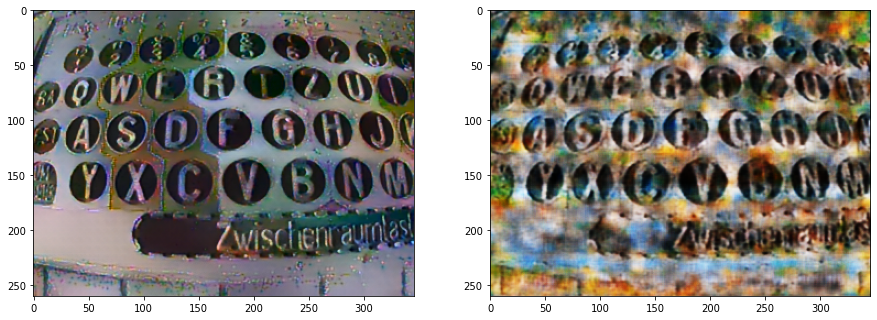

In [16]:
from models.transformer import VisionTransformerConv
ckpt = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\Materiale da mostrare\12-05\lightning_logs\Large - 1 il, 1e-2 fl, bn relu, maxpool, polarity fix\checkpoints\epoch=175-step=11088.ckpt"
my_model = VisionTransformerConv.load_from_checkpoint(ckpt)

from dataset_utils import dataset_generator_from_bag
from dataset import CustomDataset
path = r"G:\CED Datasets\Bags\simple_color_keyboard_2.bag"

gen = dataset_generator_from_bag(path, min_n_events=int(346 * 260 * 0.35), n_temp_bins=5)
my_gen = iter(dataset_generator_from_bag(path, min_n_events=int(346 * 260 * 0.35), n_temp_bins=10))
for events, image in gen:
    events = torch.from_numpy(events.astype(np.float32)).unsqueeze(0)
    image = torch.from_numpy(image.astype(np.float32)).unsqueeze(0)
    output = model.predict_images((events, image))

    my_events, _ = next(my_gen)
    my_events = torch.from_numpy(my_events.astype(np.float32)).unsqueeze(0)
    my_output = my_model.predict_images((my_events, image))[0].detach().cpu().permute(1, 2, 0)

    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(output)
    plt.subplot(1, 2, 2)
    plt.imshow(my_output)

    plt.show()

    break

## Events count for presentation

In [4]:
from tqdm import tqdm
from dataset import DIV2KDataset
import rosbag
from dataset_utils import rosbag_images_generator

base_path = r"C:\datasets\DIV2K BAGS"

n_frames = 6
bags_num_events = []

for bag in tqdm(sorted(os.listdir(base_path))):
    path = os.path.join(base_path, bag)

    with rosbag.Bag(path) as b:
        img_gen = iter(rosbag_images_generator(b, "/cam0/image_raw"))
        for i in range(n_frames):
            img_ts, img = next(img_gen)
        # img_ts is the timestamp of the n_frames-th image

    with rosbag.Bag(path) as b:
        messages = b.read_messages(topics=["/cam0/events"])
        num_events = 0
        for topic, msg, timestamp in messages:
            events = msg.events
            for event in events:
                num_events += 1
                if event.ts.to_sec() > img_ts:
                    break
            if event.ts.to_sec() > img_ts:
                    break
        
        bags_num_events.append(num_events)

total_events = sum(bags_num_events)
min_events = min(bags_num_events)
max_events = max(bags_num_events)
avg_events = total_events / len(bags_num_events)
print("Total events: {}, Min events: {}, Max events: {}, Average events: {}".format(total_events, min_events, max_events, avg_events))

Total events: 987813811, Min events: 4841, Max events: 8996649, Average events: 1097570.901111111
